<a id='section_1'></a>
# Сталелитейная промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «**Так закаляем сталь**» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет конечную температуру стали.
- **Целевой признак** - это последнее измерение _температуры_ партии из таблицы `data_temp_new.csv`
- Метрика: _МАЕ_ (mean_squared_error)
- Значение: 6.8 или ниже.

**Описание этапа обработки**

Сталь обрабатывают в _сталелитейном ковше_ вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. 

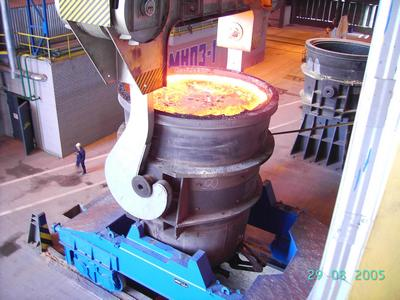

Расплавленную сталь заливают в ковш и подогревают до нужной температуры _графитовыми электродами_. Они установлены в крышке ковша.

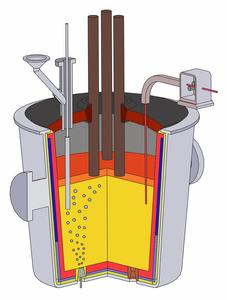

Из сплава выводится сера (процесс _десульфурации_), добавлением примесей корректируется химический состав и отбираются пробы. Сталь _легируют_ (изменяют её состав) — подавая куски сплава из бункера для сыпучих материалов или добавляя проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

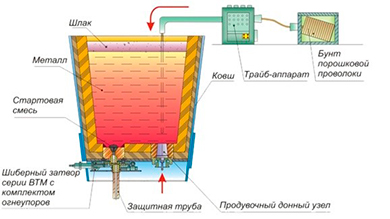

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

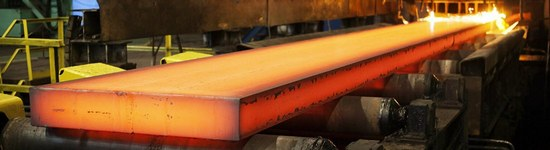

**План проекта:**
1. [Описание проекта и тех. процесса](#section_1)
2. [Знакомство с данными](#section_2)
    1. [Подготовка](#section_2A)
    1. [Чтение данных](#section_2B)
    1. [Анализ данных (EDA)](#section_2C)
3. [Предобработка данных](#section_3)
    1. [Стандартизация названий колонок](#section_3A)
    2. [Обработка пропусков](#section_3B)
4. [Формирование (обуч. + тест.) выборок данных](#section_4)
    1. [Создание новых признаков](#section_4A)
    2. [Выделение признаков](#section_4B)
    3. [Валидация данных](#section_4C)
5. [Обучение моделей](#section_5)
    1. [Линейная регрессия (LR)](#section_5A)
    2. [Случайный лес (RF)](#section_5B)
    3. [CatBoost (CB)](#section_5C)
    4. [Проверка моделей на адекватность](#section_5D)
6. [Итоговое тестирование](#section_6)
7. [Итоговый вывод (отчёт)](#section_7)
8. [Список вопросов для заказчика](#section_8)

___
<a id='section_2'></a>
## Чтение и знакомство с данными

<a id='section_2A'></a>
### Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
SEED = 150523
FILE_NAMES = ['data_arc_new.csv',
              'data_bulk_new.csv',
              'data_bulk_time_new.csv',
              'data_gas_new.csv',
              'data_temp_new.csv',
              'data_wire_new.csv',
              'data_wire_time_new.csv']

<a id='section_2B'></a>
### Чтение данных

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные о времени и количестве нагрева полученные с _графитовых электродов_ [(source)](https://code.s3.yandex.net/datasets/data_arc_new.csv);
- `data_bulk_new.csv` — данные об объёме подаче сыпучих легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_bulk_new.csv);
- `data_bulk_time_new.csv` — данные о времени подаче сыпучих легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_bulk_time_new.csv);
- `data_gas_new.csv` — данные о продувке сплава _инертным газом_ [(source)](https://code.s3.yandex.net/datasets/data_gas_new.csv);
- `data_temp_new.csv` — результаты измерения температуры сплава [(source)](https://code.s3.yandex.net/datasets/data_temp_new.csv);
- `data_wire_new.csv` — данные об объёме проволочных легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_wire_new.csv);
- `data_wire_time_new.csv` — данные о времени проволочных легирующих присадок [(source)](https://code.s3.yandex.net/datasets/data_wire_time_new.csv).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [15]:
for file in FILE_NAMES:
    df = pd.read_csv('datasets/' + file)
    print('ДАТАСЕТ:', file)
    print(df.info())
    display(df.head())
    print('\n'*3)

ДАТАСЕТ: data_arc_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691






ДАТАСЕТ: data_bulk_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0






ДАТАСЕТ: data_bulk_time_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47






ДАТАСЕТ: data_gas_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692






ДАТАСЕТ: data_temp_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0






ДАТАСЕТ: data_wire_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN






ДАТАСЕТ: data_wire_time_new.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='section_2C'></a>
### Анализ данных (EDA)

В конце Jupyter Notebook напишите:
- Список уточняющих вопросов.
- Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.
- Цель проекта.

Ваш исследовательский анализ, вопросы и план проверит тимлид. Свою обратную связь он даст во время вебинара.

**Заключение по исходным датасетам:**

___
<a id='section_3'></a>
## Предобработка данных

<a id='section_3A'></a>
### Стандартизация названий колонок

<a id='section_3B'></a>
### Обработка пропусков

**Вывод:**

___
<a id='section_4'></a>
## Формирование (обуч. + тест.) выборок данных

___
<a id='section_4A'></a>
### Создание новых признаков

___
<a id='section_4B'></a>
### Выделение признаков

___
<a id='section_4C'></a>
### Валидация данных

**Вывод:**

___
<a id='section_5'></a>
## Обучение модели

<a id='section_5A'></a>
### Линейная регрессия (LR)

<a id='section_5B'></a>
### Случайный лес (RF)

<a id='section_5C'></a>
### CatBoost (CB)

<a id='section_5D'></a>
### Проверка моделей на адекватность

**Вывод:**

___
<a id='section_6'></a>
## Итоговое тестирование

___
<a id='section_7'></a>
## Итоговый вывод (отчёт)

___
<a id='section_8'></a>
## ~Список вопросов для заказчика~

По всем вопросам получил ответ на прошедшем вебинаре. Спасибо за пояснения. **Вопросов нет.** Всё ниже перечисленное решил не удалять, следую совету с того же вебинара.

1. Столбец `key` намекает, что в этом проекте потребуется использовать запросы `SQL`. Верно ли я предполагаю?
2. Есть ли документация для датасетов? Какие данные содержатся столбце таблицы?
3. В датасете `data_arc_new.csv` c данными об электродах, находятся столбцы `Активная мощность` и `Реактивная мощность`. Они содержат электрическую и тепловую мощность, соответственно?
4. В датасете `data_bulk_new.csv`, что подразумевается под названием `Bulk_1`, `Bulk_2` и т.д.? Это виды сыпучих легирующих присадок и их объём, добавленный в сплав?
5. В датасете `data_temp_new.csv`, столбец `Газ 1` - содержит **количество** поданного инертного газа для продувки сплава? Если существует столбец `Газ 1` существует ли столбец `Газ 2`, `Газ 3`, ... ?
6. В датасете `data_wire_new.csv`, что подразумевается под названием `Wire_1`, `Wire_2` и т.д.? Это виды проволочных легирующих присадок и их объём, добавленный в сплав?
7. Правильно ли я понял, что легирующие присадки могут быть в виде сыпучих материалов или проволоки?
8. Общее количество партий: 3129?
9. Целевой признак - это столбец `Температура` в таблице `data_temp_new.csv`, верно?
10. Какая метрика качества (MSE, SMAPE, R2 или др.)?
___